In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

In [24]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

In [2]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,gLM-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7
8,CADD+GPN-MSA+Borzoi,Ensemble,C8


In [17]:
dataset_renaming = {
    "mendelian_traits_all": "Mendelian traits",
    "old/complex_traits_all": "Complex traits",
}

subset_renaming = {
    "all": "All",
}

In [18]:
datasets = [
    "mendelian_traits_all",
    "old/complex_traits_all",
]

subsets = [
    "all",
]

models = [
    "GPN-MSA",
    "CADD",
]

def load_score(model, dataset, subset):
    base_dir = f"../../results/dataset/{dataset}/unsupervised_metrics/{subset}"
    if model != "CADD":
        if "mendelian" in dataset:
            llr_version = "LLR"
        elif "complex" in dataset:
            llr_version = "absLLR"
        path = f"{base_dir}/{model}_{llr_version}.csv"
    else:
        path = f"{base_dir}/{model}.csv"
    df = pd.read_csv(path)
    if model == "CADD":
        return df[df.feature=="RawScore"].AUPRC.values[0]
    else:
        return df.AUPRC.values[0]

In [19]:
sample_size = {}
for dataset in datasets:
    V = pl.read_parquet(f"../../results/dataset/{dataset}/test.parquet")
    n = len(V)
    n_pos = V["label"].sum()
    sample_size[dataset_renaming.get(dataset, dataset)] = (n_pos, n-n_pos)
sample_size

{'Mendelian traits': (339, 4945336), 'Complex traits': (847, 5423088)}

In [20]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for model in models:
            score = load_score(model, dataset, subset)
            rows.append([
                dataset_renaming.get(dataset, dataset),
                subset_renaming.get(subset, subset),
                model_renaming.get(model, model),
                score,
            ])
df = pd.DataFrame(rows, columns=["dataset", "subset", "model", "AUPRC"])
df

,dataset,subset,model,AUPRC
0,Mendelian traits,All,GPN-MSA,0.080031
1,Mendelian traits,All,CADD,0.011185
2,Complex traits,All,GPN-MSA,0.000846
3,Complex traits,All,CADD,0.001035


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

Mendelian traits 6.85E-05
Complex traits 1.56E-04


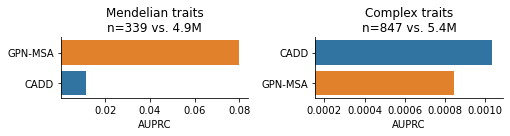

In [31]:
g = sns.FacetGrid(
    data=df,
    col="dataset",
    sharex=False,
    sharey=False,
    height=2,
    aspect=1.8,
)

def my_boxplot(data, **kwargs):
    dataset = data.dataset.iloc[0]
    n_pos, n_neg = sample_size[dataset]
    data = data.sort_values("AUPRC", ascending=False)
    ax = plt.gca()
    g = sns.barplot(
        data=data,
        y="model",
        x="AUPRC",
        ax=ax,
        palette=palette,
    )
    baseline = n_pos / (n_pos + n_neg)
    ss = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
    print(dataset, f"{baseline:.2E}")
    g.set(
        xlim=baseline,
        title=f"{dataset}\n{ss}"
    )

g.map_dataframe(my_boxplot)
#g.figure.subplots_adjust(hspace=0)

g.set(
    ylabel="",
)
#g.set_titles(
#    col_template="{col_name}", row_template="{row_name}",
#    fontweight="bold",
#    #size=12,
#)
g.tight_layout()
#plt.savefig("../../results/plots/performance_all.pdf", bbox_inches="tight")